In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats 
import statsmodels.formula.api as smf
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


df = pd.read_csv('kc_house_data.csv')

# Examine first several rows

df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [2]:
 # Id column adds no predictive value. Drop column
df = df.drop('id', axis=1)

In [3]:
# Convert date column to datetime
df.date = pd.to_datetime(df.date) 

# Change zipcode values into categories as there is no numerical relationship between the zipcode
# values
df.zipcode = df.zipcode.astype('category')

# Convert df.sqft_basement from string to float
# There are 454 '?' in the column values. Replace '?' with NaN for now and convert column to float
# to get initial statistical summary to help decide how to handle NaN values

df.sqft_basement = df.sqft_basement.replace('?', np.nan)

df.sqft_basement = df.sqft_basement.astype('float64')

df.info() #check

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
date             21597 non-null datetime64[ns]
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21143 non-null float64
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null category
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: category(1), datetime64[ns](1), float64(9), int64(9)
memory usage: 3.2 MB


In [4]:
# Check df for NaN values
df.isna().sum()

date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement     454
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [5]:
# 63 null values in 'view' is negligible compared to the size of the df. Drop null values
df = df.dropna(subset=['view'], axis=0)

There are too many null values in 'waterfront', 'sqft_basement', and 'yr_renovated' to drop without evaluation. Compare the null values for each column to the set of that column's data equal to 0 with a one sample z-test (based on price) and alpha of 0.05. If the test yeilds a p-value greater than 0.05, the two sets of data are not significantly different. Convert the null values to 0 for these columns. If the p-value is less than 0.05, the two sets of data are significantly different from each other. Perform another z-test (based on price) between the null values and the set of the corresponding column's data that is greater than 0. If the test yeilds a p-value greater than 0.05, the null vales and the set of data with values greater than 0 are not significantly different. Convert the null values to the median value of that column.

In [6]:
# Z-test 'waterfront'
nan_water = df.loc[df['waterfront'].isna()] #sample
zero_water = df.loc[df['waterfront'] == 0] #population

z_stat1 = (nan_water.price.mean() - zero_water.price.mean()) / (zero_water.price.std() / np.sqrt(len(nan_water.price)))

p_value1 = 1 - stats.norm. cdf(z_stat1)
print(f'P-value waterfront: {p_value1}')

# Z-test 'yr_renovated'
nan_reno = df.loc[df['yr_renovated'].isna()] #Sample
zero_reno = df.loc[df['yr_renovated'] == 0] #Population

z_stat2 = (nan_reno.price.mean() - zero_reno.price.mean()) / (zero_reno.price.std() / np.sqrt(len(nan_reno.price)))

p_value2 = 1 - stats.norm. cdf(z_stat2)
print(f'P-value yr_renovated: {p_value2}')

# Z-test 'sqft_basement' NaN vs 0
nan_basement = df.loc[df['sqft_basement'].isna()] #sample
zero_basement = df.loc[df['sqft_basement'] == 0] #population

z_stat3 = (nan_basement.price.mean() - zero_basement.price.mean()) / (zero_basement.price.std() / np.sqrt(len(nan_basement.price)))

p_value3 = 1 - stats.norm. cdf(z_stat3)
print(f'P-value sqft_basement NaN vs 0: {p_value3}')

# Z-test 'sqft_basement' NaN vs > 0
nan_basement = df.loc[df['sqft_basement'].isna()] #sample
yes_basement = df.loc[df['sqft_basement'] > 0] #population

z_stat4 = (nan_basement.price.mean() - yes_basement.price.mean()) / (yes_basement.price.std() / np.sqrt(len(nan_basement.price)))

p_value4 = 1 - stats.norm.cdf(z_stat4)
print(f'P-value sqft_basement NaN vs > 0: {p_value4}')



P-value waterfront: 0.7072254172744156
P-value yr_renovated: 0.07224905572756746
P-value sqft_basement NaN vs 0: 0.0008189419886436289
P-value sqft_basement NaN vs > 0: 0.9999943139206572


In [7]:
# Convert 'waterfront' null values to 0
df['waterfront'] = df['waterfront'].replace(np.nan, 0)

# Convert 'yr_renovated' null values to 0
df['yr_renovated'] = df['yr_renovated'].replace(np.nan, 0)

# Convert 'sqft_basement' null values to column median
median = yes_basement['sqft_basement'].median()

df['sqft_basement'] = df['sqft_basement'].replace(np.nan, median)

df.isna().sum() # Check

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [8]:
# Create new columns named 'raw_price', 'raw_lat', 'raw_long', 'raw_built', and 'raw_living' 
# to preserve actual values for visualizations

df['raw_price'] = df.price
df['raw_lat'] = df.lat
df['raw_long'] = df.long
df['raw_built'] = df.yr_built
df['raw_living'] = df.sqft_living
df['raw_grade'] = df.grade

In [9]:
# The non-zero values in 'yr_renovated' and 'sqft_basement' were sparse. Make the 'yr_renovated'
# column binary by setting all non-zero values equal to 1.

df['renovated'] = df['yr_renovated']

for val in df['renovated']:
    if val != 0:
        df['renovated'].replace(val, 1, inplace=True)

df.renovated.value_counts() # Check

0.0    20791
1.0      743
Name: renovated, dtype: int64

In [10]:
df = df.drop('yr_renovated', axis=1) # Drop yr_renovated as the data is now stored in 'renovated'

In [11]:
# Bin the data in 'sqft_basement'

bins = [-1, 1, 500, 1000, 5000]

df['basement_bin'] = pd.cut(df['sqft_basement'], bins)
df.basement_bin.astype('category')

df.columns # Check

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'raw_price', 'raw_lat', 'raw_long', 'raw_built',
       'raw_living', 'raw_grade', 'renovated', 'basement_bin'],
      dtype='object')

In [12]:
df = df.drop('sqft_basement', axis=1) # Drop 'sqft_basement', as the data is now stored in 
                                      # 'basement_bin'
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'raw_price', 'raw_lat', 'raw_long', 'raw_built', 'raw_living',
       'raw_grade', 'renovated', 'basement_bin'],
      dtype='object')

In [13]:
# Get the statistical summary

df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,long,sqft_living15,sqft_lot15,raw_price,raw_lat,raw_long,raw_built,raw_living,raw_grade,renovated
count,2.153400e+04,21534.000000,21534.000000,21534.000000,2.153400e+04,21534.000000,21534.000000,21534.000000,21534.000000,21534.000000,...,21534.000000,21534.000000,21534.000000,2.153400e+04,21534.000000,21534.000000,21534.000000,21534.000000,21534.000000,21534.000000
mean,5.400577e+05,3.373038,2.115712,2079.827854,1.509060e+04,1.494126,0.006734,0.233863,3.409724,7.657425,...,-122.213948,1986.299944,12751.079502,5.400577e+05,47.560180,-122.213948,1971.002275,2079.827854,7.657425,0.034504
std,3.660596e+05,0.926410,0.768602,917.446520,4.138021e+04,0.539806,0.081783,0.765686,0.650654,1.172643,...,0.140735,685.121001,27255.483308,3.660596e+05,0.138528,0.140735,29.376044,917.446520,1.172643,0.182523
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,...,-122.519000,399.000000,651.000000,7.800000e+04,47.155900,-122.519000,1900.000000,370.000000,3.000000,0.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,...,-122.328000,1490.000000,5100.000000,3.220000e+05,47.471200,-122.328000,1951.000000,1430.000000,7.000000,0.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.617000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,...,-122.230000,1840.000000,7620.000000,4.500000e+05,47.571900,-122.230000,1975.000000,1910.000000,7.000000,0.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068775e+04,2.000000,0.000000,0.000000,4.000000,8.000000,...,-122.125000,2360.000000,10083.000000,6.450000e+05,47.678100,-122.125000,1997.000000,2550.000000,8.000000,0.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,...,-121.315000,6210.000000,871200.000000,7.700000e+06,47.777600,-121.315000,2015.000000,13540.000000,13.000000,1.000000


Standardize the data by converting all non-binary and non-categorical feature data to a z-score. Since a z-score represents the number of deviations from the mean, drop all values greater than 3 standard deviations from their mean to remove outliers from the data.

In [14]:
# Standardize all non-binary and non-categorical features for modeling
zscore = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'view',
          'condition', 'grade','sqft_above', 'yr_built', 'lat', 'long','sqft_living15', 
          'sqft_lot15']
for col in zscore:
    df[col] = (df[col] - df[col].mean()) / df[col].std()


In [15]:
# Convert all values greater than 3 to NaN, and then drop all null values from the df

for column in zscore:
    for val in df[column]:
        if val >= 3:
            df[column] = df[column].replace(val, np.nan)
        

#df.isna().sum() # Check     
        

In [16]:
df_clean = df.dropna()
df_clean.isna().sum() # Check

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
yr_built         0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
raw_price        0
raw_lat          0
raw_long         0
raw_built        0
raw_living       0
raw_grade        0
renovated        0
basement_bin     0
dtype: int64

Feature engineer a new column to help interprete the latitude and longitude data. 

* The column 'distance_h2o' will contain the data that represent the absolute value of the difference between each data point's latitude value with the median latitude value of the set 'waterfront' = 1.


In [17]:
h2o = df_clean.loc[df_clean['waterfront'] == 1]
wlat_median = h2o.raw_lat.median()

no_h2o = df_clean.loc[df_clean['waterfront'] != 1]
nwlong_median = no_h2o.raw_long.median()

def dist_water (data1, median1):
    distance_lat = []
    for val1 in data1:
        distance_lat.append(abs(val1 - median1))
    return distance_lat

distance_h2o = dist_water(df_clean.raw_lat, wlat_median)

df_clean['distance_h2o'] = distance_h2o # Create new column 'distance_h2o'
df_clean['distance_h2o'] = ((df_clean.distance_h2o - df_clean.distance_h2o.mean()) / 
                            df_clean.distance_h2o.std()) # Standardize the data

df_clean.columns # Check


/Users/kpokrass_pro/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/kpokrass_pro/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'raw_price', 'raw_lat', 'raw_long', 'raw_built', 'raw_living',
       'raw_grade', 'renovated', 'basement_bin', 'distance_h2o'],
      dtype='object')

In [18]:
# Create a df with the data that will be used for visualizations
viz_data = df_clean[['raw_price', 'raw_lat', 'raw_long', 'zipcode', 'raw_built', 'waterfront',
                    'renovated', 'distance_h2o', 'raw_living', 'raw_grade']]
viz_data.head()

,raw_price,raw_lat,raw_long,zipcode,raw_built,waterfront,renovated,distance_h2o,raw_living,raw_grade
0,221900.0,47.5112,-122.257,98178,1955,0.0,0.0,-0.898638,1180,7
1,538000.0,47.7210,-122.319,98125,1951,0.0,1.0,1.318815,2570,7
2,180000.0,47.7379,-122.233,98028,1933,0.0,0.0,1.497438,770,6
3,604000.0,47.5208,-122.393,98136,1965,0.0,0.0,-0.797172,1960,7
4,510000.0,47.6168,-122.045,98074,1987,0.0,0.0,0.217487,1680,8


In [19]:
df_clean = df_clean.drop(['raw_price', 'raw_lat', 'raw_long', 'raw_built', 'raw_living', 'raw_grade'], axis=1)
df_clean.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'renovated', 'basement_bin', 'distance_h2o'],
      dtype='object')

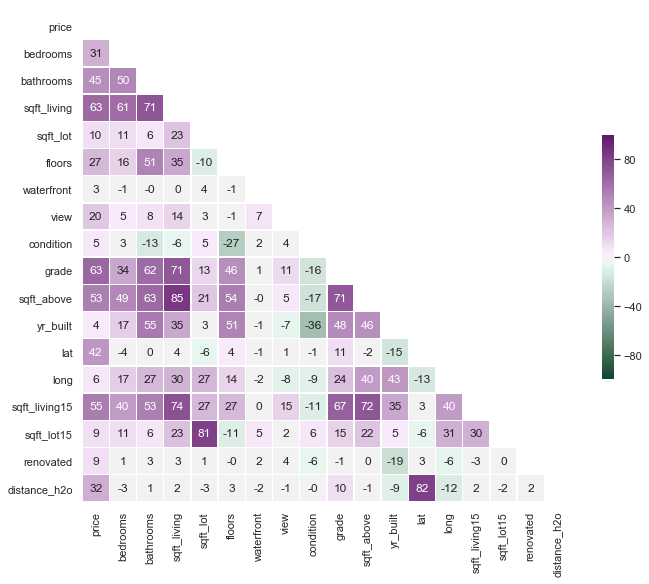

In [20]:
# Check the features for multicollinearity

sns.set(style="white")

corr = df_clean.corr() # Create covariance matrix

mask = np.zeros_like(corr, dtype=np.bool) # Remove half of the heatmap as it is reflection along the diagonal
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9)) # Create and set figure size

cmap = sns.diverging_palette(145, 300, s=85, l=25, n=7, as_cmap=True) # Define color scheme

sns.heatmap(corr*100, annot=True, fmt='.0f', mask=mask, cmap=cmap, vmax=100, vmin=-100, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}) # Create heatmap with correlation values for each
                                                                 # feature


The columns 'sqft_above' and 'sqft_lot15' each have a relatively high correlation with another column ('sqft_living' and 'sqft_lot', respectively). Consider dropping from model to improve r-squared and MSE, if necessary. Additionally, consider dropping 'yr_renovated' due to collinearity with 'renovated'.

# Check for normality in the distributions

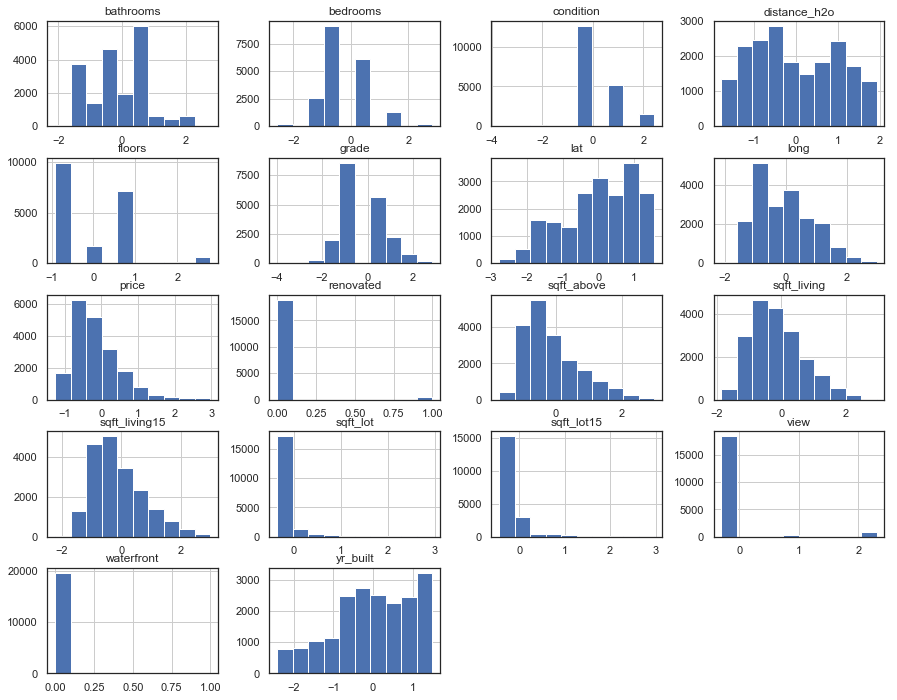

In [21]:
# Check distributions with histograms

df_clean.hist(figsize=[15,12])
plt.show()

Most of the features have a realtively normal distribution with close to equal ranges. The features 'sqft_living', 'sqft_living15', 'sqft_above', 'sqft_basement', 'price', 'long', 'yr_built' appear to be mildyl skewed, but not enought to warrant action. The columns 'renovated' and 'waterfront' are binary and thus can be disregarded. 

# Check for linearity and homoscedasticity

In [22]:
df_clean.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'renovated', 'basement_bin', 'distance_h2o'],
      dtype='object')

/Users/kpokrass_pro/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


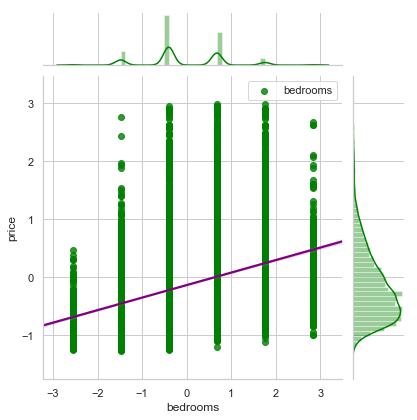

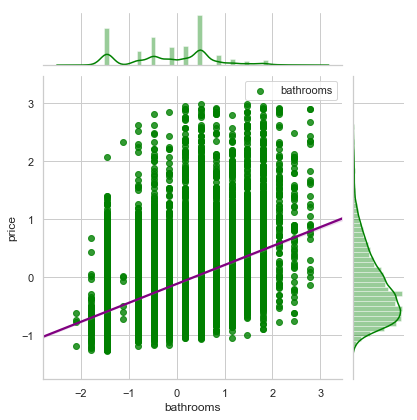

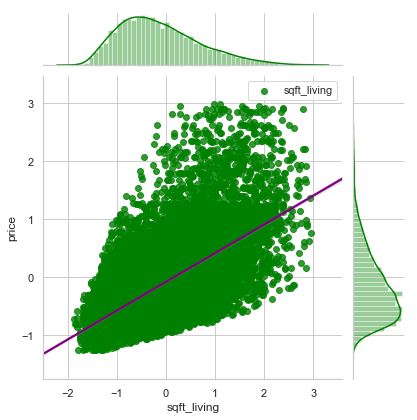

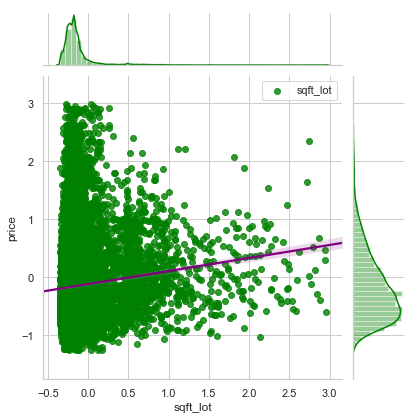

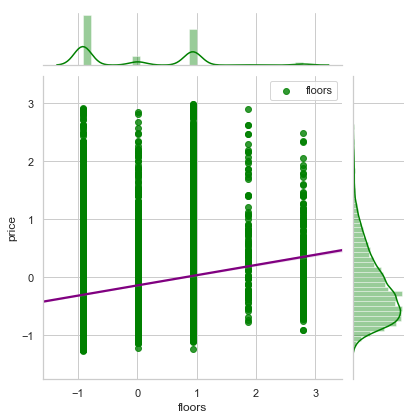

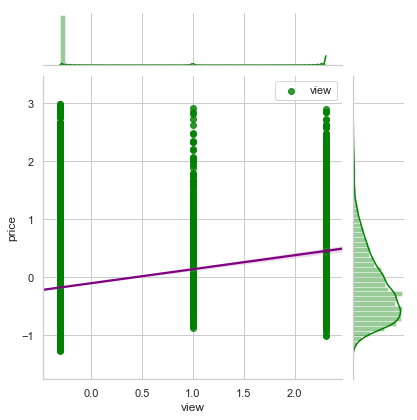

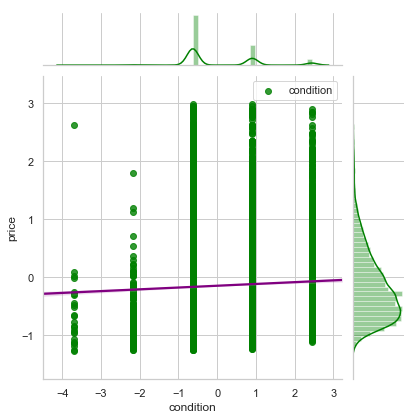

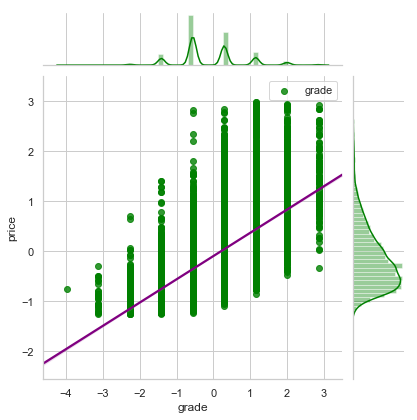

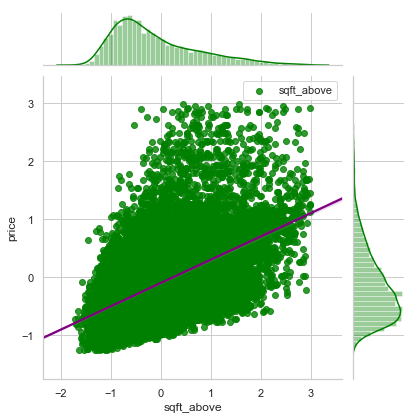

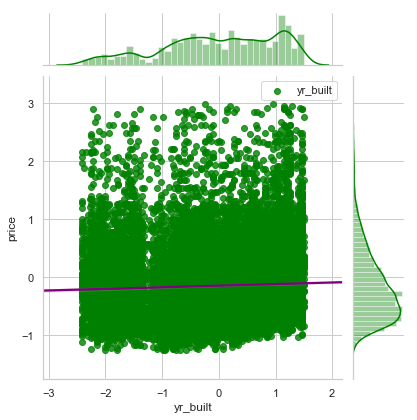

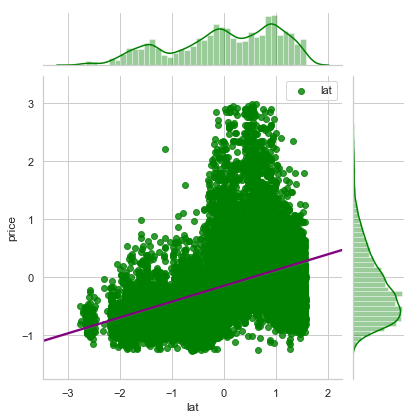

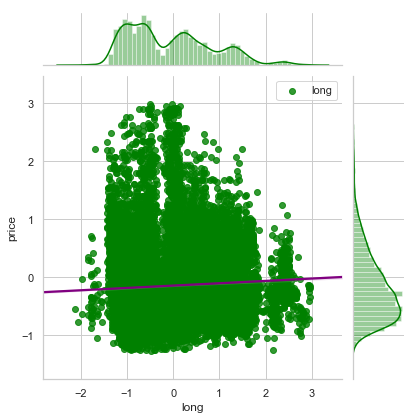

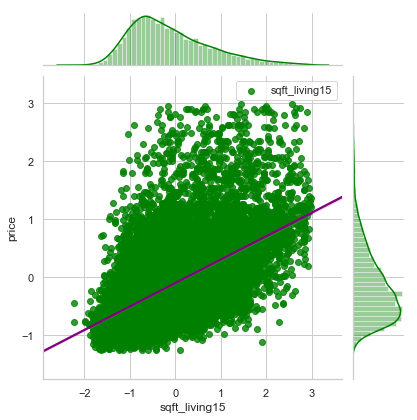

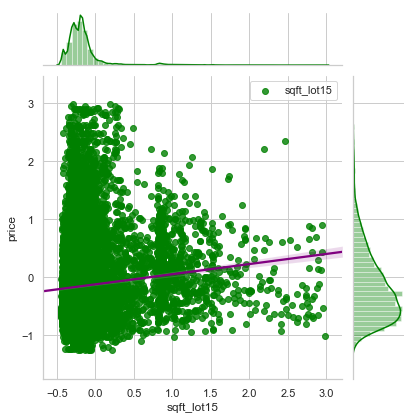

In [23]:
sns.set(style='whitegrid') # Set background style of plots
for column in ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'view',
              'condition', 'grade', 'sqft_above', 'yr_built', 'lat', 'long',
              'sqft_living15', 'sqft_lot15']: # Iterate through columns of continuous predictors to create a jointplot for each
    sns.jointplot(x=column, y='price', data=df_clean, kind='reg', color='green', label=column,
                 joint_kws={'line_kws':{'color':'purple'}})
    #sns.regplot(df2[column], df2.log_price, label=column)
    plt.legend()
    plt.show()

Most of the features appear to have a relatively linear trend. The features 'sqft_living', 'sqft_living15', 'sqft_above', and 'lat' show some evidence of heteroscedasticity and should be considered when evaluating model strength. The features 'bedrooms', 'bathrooms', 'floors', 'view', 'condition', and 'grade' are clustering at discrete values. Proceed as is with modeling since there is a numerical relationship between the discrete values for these features, but consider binning to improve model if necessary.

# Does the age of the house affect its sale price?

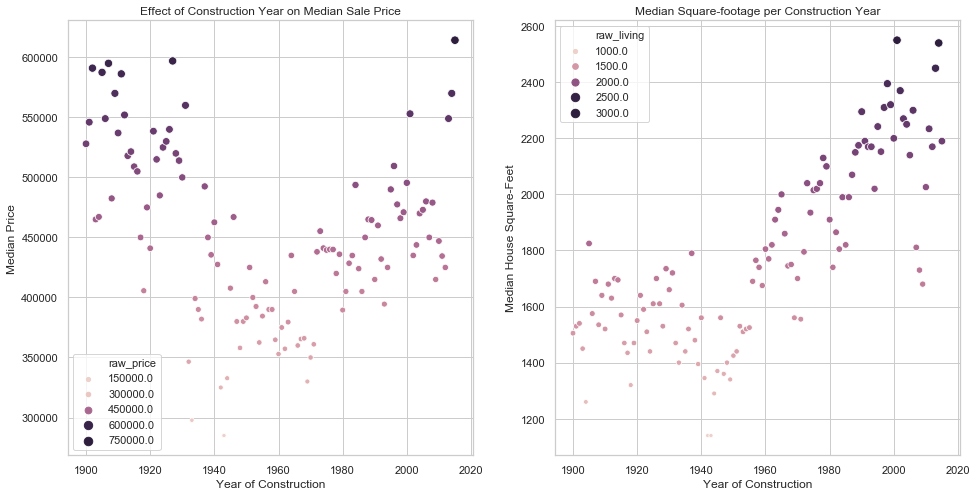

In [24]:
sns.set(style='whitegrid')
grouped1 = viz_data.groupby(['raw_built'])['raw_built', 'raw_price'].aggregate(np.median)
grouped2 = viz_data.groupby(['raw_built'])['raw_built', 'raw_living'].aggregate(np.median)
figure = plt.figure(figsize=[16,8])
plt.subplot(1,2,1)
sns.scatterplot(x='raw_built', y='raw_price', data=grouped1, hue='raw_price', size='raw_price')
plt.title('Effect of Construction Year on Median Sale Price')
plt.xlabel('Year of Construction')
plt.ylabel('Median Price')

plt.subplot(1,2,2)
sns.scatterplot(x='raw_built', y='raw_living', data=grouped2, hue='raw_living', size='raw_living')
plt.title('Median Square-footage per Construction Year')
plt.xlabel('Year of Construction')
plt.ylabel('Median House Square-Feet')

plt.show()

Homes built circa 1960 have several potential issues that could affect sale price. First, asbestos was used in many of the building components and can introduce fibers into the air if disturbed.  Second, galvanized steel piping was used until the early 1970s. These pipes last roughtly 40-50 years and rust from the inside. Thus, most of the plumbing in the houses built in the 1960s would have been failing around the time of sale for this data set. Third, foundation type (concrete slab on grade) of this ear of contruction is prone to cracking and deterioration due to soil erosion. All of these issues could be identified during a pre-sale inspection and the buyers could ask for the cost of the repairs to be deducted from the sale price, resulting in the lower median sale price for houses built in the 1960s. Furthermore, earlier era houses were smaller than more recently contructed houses. The second graph indicates that house size began to increase just prior to 1960 and that upward trend in house size is mirrored by an upward trend in house price as shown in the first graph.

source: http://www.mcgarryandmadsen.com/Blog/Entries/2015/8/9_What_are_the_common_problems_to_look_for_when_buying_a_1960s_house.html

# Put this data in context geographically

What is the median sale price for each zipcode and where is each zipcode in relation to Seattle, WA?

source: https://alysivji.github.io/getting-started-with-folium.html

In [25]:
import folium
from folium import plugins

In [26]:
# Create a df grouped by zipcode and aggregated by the median for raw price, lat, and long
zip_group = viz_data.groupby(['zipcode'])['zipcode', 'raw_price', 'raw_lat', 'raw_long', 'raw_built'].median()
zip_group['raw_price'] = zip_group['raw_price'].astype('str')
zip_group.info()


<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 70 entries, 98001 to 98199
Data columns (total 4 columns):
raw_price    70 non-null object
raw_lat      70 non-null float64
raw_long     70 non-null float64
raw_built    70 non-null float64
dtypes: float64(3), object(1)
memory usage: 5.3+ KB


In [29]:
map_kc = folium.Map([47.5718, -122.2310], zoom_start=11)
for index, row in zip_group.iterrows():
    folium.CircleMarker([row['raw_lat'], row['raw_long']], popup=row['raw_price'], color='blue').add_to(map_kc)
map_kc

The folium map is an interactive vizualization where each marker represents one of the zipcodes in the data set placed by median latitude and longitude coordinates for each zipcode. Additionally, clicking on a marker will pull up the median sale price for that zipcode. Most of the zipcodes contained in this data set are east of Seattle and seem to cluster around Kirkland, WA.

# Are the Bones Good?

Were older houses constructed with better materials and craftsmanship than newer houses based on the King County, WA grading system?

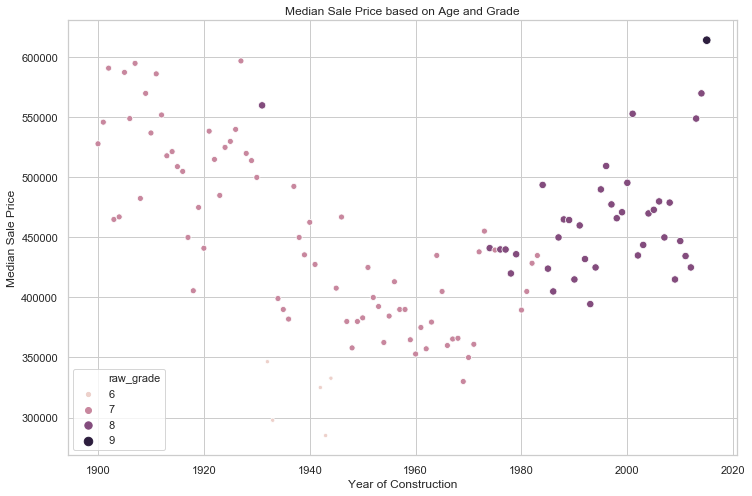

In [30]:
group3 = viz_data.groupby(['raw_built'])['raw_built', 'raw_grade', 'raw_price'].median()

fig = plt.figure(figsize=[12,8])
sns.scatterplot(x='raw_built', y='raw_price', data=group3, hue='raw_grade', size='raw_grade')
plt.title('Median Sale Price based on Age and Grade')
plt.xlabel('Year of Construction')
plt.ylabel('Median Sale Price')
plt.savefig('grade.pdf')
plt.show()

Again, the median sale price was plotted against the year of cronstruction. However, the point size and color in this graph correspond to the grade given to the house based on the King Count, WA grading system. If older houses were constructed with better materials and craftsmanship than modern era houses, the larger, darker points would be clustered on the left side of the graph. The opposite trend is observed by the data. The larger, darker points are on the right, suggesting newer homes are of better quality than older homes based on this grading system. This grading system could be biased towards homes of newer construction as older homes would not have been forced to meet the same safety codes. Furthermore, older homes would have been subjected to greater "wear and tear" than newer at the time of grading.

In [31]:
# Calculate regression statistics for continuous features

columns = df_clean.columns.drop(['price', 'basement_bin','zipcode'])
results = [['feature', 'slope', 'intercept', 'r-squared', 'adj r-squared', 'p-value']]

for col, val in enumerate(columns):
    f='price~'+ val
    model=smf.ols(formula=f, data=df_clean).fit()
    x_new = pd.DataFrame({val: [df_clean[val].min(), df_clean[val].max()]})
    predict = model.predict(x_new)
    results.append([val, model.params[1], model.params[0], model.rsquared, model.rsquared_adj, model.pvalues[1]])
    
df_results = pd.DataFrame(results)
df_results

,0,1,2,3,4,5
0,feature,slope,intercept,r-squared,adj r-squared,p-value
1,date,0.0542143,-0.110938,0.0231369,0.00425494,0.88729
2,bedrooms,0.215619,-0.13542,0.0948919,0.0948455,0
3,bathrooms,0.326341,-0.115525,0.206738,0.206697,0
4,sqft_living,0.495566,-0.0811209,0.391364,0.391333,0
5,sqft_lot,0.224423,-0.118176,0.00936213,0.00931135,8.25773e-42
6,floors,0.175958,-0.141205,0.0733009,0.0732534,0
7,waterfront,1.17772,-0.146625,0.000846425,0.000795215,4.81099e-05
8,view,0.241335,-0.103561,0.0405782,0.0405291,8.84025e-178
9,condition,0.0308307,-0.146501,0.00227015,0.00221901,2.75717e-11


The r-squared values for these features are fairly low, indicating that none of the features are particularly robust predictors. However, the all of the p-values, except for 'date', are less than 0.05. This suggests that these features do affect the sale price of the house to some degree.

In [32]:
# Drop 'date' as it's p-value is too large to include it as a predictor in the model.
df_clean = df_clean.drop('date', axis=1)
df_clean.columns # Check

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'yr_built',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'renovated',
       'basement_bin', 'distance_h2o'],
      dtype='object')

In [33]:
# Get dummy variables for the categorical data

df_clean = pd.get_dummies(df_clean)
df_clean.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'yr_built',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'renovated',
       'distance_h2o', 'zipcode_98001', 'zipcode_98002', 'zipcode_98003',
       'zipcode_98004', 'zipcode_98005', 'zipcode_98006', 'zipcode_98007',
       'zipcode_98008', 'zipcode_98010', 'zipcode_98011', 'zipcode_98014',
       'zipcode_98019', 'zipcode_98022', 'zipcode_98023', 'zipcode_98024',
       'zipcode_98027', 'zipcode_98028', 'zipcode_98029', 'zipcode_98030',
       'zipcode_98031', 'zipcode_98032', 'zipcode_98033', 'zipcode_98034',
       'zipcode_98038', 'zipcode_98039', 'zipcode_98040', 'zipcode_98042',
       'zipcode_98045', 'zipcode_98052', 'zipcode_98053', 'zipcode_98055',
       'zipcode_98056', 'zipcode_98058', 'zipcode_98059', 'zipcode_98065',
       'zipcode_98070', 'zipcode_98072', 'zipcode_98074', 'zipcode_98075',
       'zipcode_98077', 'zipco

In [34]:
# Calculate regression statistics on categorical features

results = [['feature', 'slope', 'intercept', 'r-squared', 'adj r-squared', 'p-value']]

cat_col = df_clean.columns[19:]
for col in cat_col:
    f = "price~Q('{}')".format(col)
    model = smf.ols(formula= f, data=df_clean).fit()
    results.append([col, model.params[1], model.params[0], model.rsquared, model.rsquared_adj, model.pvalues[1]])
    #print(model.summary())
    
df_results_cat = pd.DataFrame(results)
df_results_cat

,0,1,2,3,4,5
0,feature,slope,intercept,r-squared,adj r-squared,p-value
1,zipcode_98002,-0.700613,-0.139286,0.0116271,0.0115765,1.48646e-51
2,zipcode_98003,-0.556388,-0.138568,0.0101362,0.0100854,3.87307e-45
3,zipcode_98004,1.44445,-0.162831,0.0561518,0.0561034,3.46499e-247
4,zipcode_98005,0.748674,-0.152155,0.01032,0.0102692,6.27368e-46
5,zipcode_98006,0.574606,-0.157719,0.0152896,0.0152391,2.42358e-67
6,zipcode_98007,0.337665,-0.148694,0.00189355,0.0018424,1.19395e-09
7,zipcode_98008,0.180173,-0.148706,0.00100894,0.000957738,9.08457e-06
8,zipcode_98010,-0.29796,-0.145102,0.000863511,0.000812302,4.03509e-05
9,zipcode_98011,-0.00287058,-0.146296,1.873e-07,-5.10658e-05,0.951797


In [35]:
df_results_cat.iloc[30:45]

,0,1,2,3,4,5
30,zipcode_98055,-0.516486,-0.139415,0.00838598,0.00833516,1.29783e-37
31,zipcode_98056,-0.233756,-0.141615,0.00256877,0.00251765,1.40088e-12
32,zipcode_98058,-0.405759,-0.137257,0.00856749,0.00851668,2.15291e-38
33,zipcode_98059,-0.0702662,-0.144753,0.000256928,0.000205688,0.0251514
34,zipcode_98065,0.049756,-0.147004,7.95909e-05,2.83418e-05,0.212705
35,zipcode_98070,-0.134142,-0.14598,0.000109555,5.83073e-05,0.143728
36,zipcode_98072,0.167805,-0.148499,0.000858436,0.000807227,4.25141e-05
37,zipcode_98074,0.424035,-0.155059,0.00864239,0.00859158,1.02588e-38
38,zipcode_98075,0.653517,-0.156672,0.0158557,0.0158052,8.7176e-70
39,zipcode_98077,0.394867,-0.149602,0.00305803,0.00300693,1.07431e-14


In [36]:
# Drop features with p-value greater than 0.05

df_clean = df_clean.drop(['zipcode_98011', 'zipcode_98034', 'zipcode_98045', 'zipcode_98136',
                         'zipcode_98144', 'zipcode_98065', 'zipcode_98070'], axis=1)
df_clean.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'yr_built',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'renovated',
       'distance_h2o', 'zipcode_98001', 'zipcode_98002', 'zipcode_98003',
       'zipcode_98004', 'zipcode_98005', 'zipcode_98006', 'zipcode_98007',
       'zipcode_98008', 'zipcode_98010', 'zipcode_98014', 'zipcode_98019',
       'zipcode_98022', 'zipcode_98023', 'zipcode_98024', 'zipcode_98027',
       'zipcode_98028', 'zipcode_98029', 'zipcode_98030', 'zipcode_98031',
       'zipcode_98032', 'zipcode_98033', 'zipcode_98038', 'zipcode_98039',
       'zipcode_98040', 'zipcode_98042', 'zipcode_98052', 'zipcode_98053',
       'zipcode_98055', 'zipcode_98056', 'zipcode_98058', 'zipcode_98059',
       'zipcode_98072', 'zipcode_98074', 'zipcode_98075', 'zipcode_98077',
       'zipcode_98092', 'zipcode_98102', 'zipcode_98103', 'zipcode_98105',
       'zipcode_98106', 'zipco

In [37]:
# Compute R-squared for model

X = df_clean.drop('price', axis=1)
y = df_clean.price

linreg = LinearRegression()

selector = RFE(linreg, n_features_to_select = 29)
selector = selector.fit(X, y)


print(selector.score(X,y))


0.7001260117569565


In [38]:
selected_features = selector.support_

selectedArr = pd.DataFrame(X.columns, selected_features)
selectedArr
only_select = selectedArr.reset_index()
only_select
final = only_select.loc[only_select['index'] == True]
final

,index,0
2,True,sqft_living
5,True,waterfront
17,True,zipcode_98001
18,True,zipcode_98002
19,True,zipcode_98003
20,True,zipcode_98004
28,True,zipcode_98022
29,True,zipcode_98023
34,True,zipcode_98030
35,True,zipcode_98031


In [39]:
estimators = selector.estimator_
coeffs = estimators.coef_
coeffs

array([ 0.45263781,  1.00072601, -0.61989377, -0.60748315, -0.59228283,
        1.17445257, -0.54905639, -0.65547753, -0.6126183 , -0.57703758,
       -0.61335541, -0.53505352,  1.75074584,  0.86552249, -0.58211406,
       -0.49827515, -0.50581028, -0.6435164 ,  0.71009271,  0.64177077,
        0.76842495,  0.89981519,  0.67229183, -0.46685037, -0.51677821,
       -0.5041357 , -0.5436461 , -0.53282621,  0.4699323 ])

In [40]:
estimators.intercept_

0.001373117391252593

In [41]:
from sklearn.metrics import r2_score

df_final = df_clean[['sqft_living', 'waterfront', 'zipcode_98001', 'zipcode_98002', 'zipcode_98003',
             'zipcode_98004', 'zipcode_98022', 'zipcode_98023', 'zipcode_98105', 'zipcode_98109',
             'zipcode_98112', 'zipcode_98119', 'zipcode_98148', 'zipcode_98168', 'zipcode_98178',
             'zipcode_98188', 'zipcode_98198', 'zipcode_98199', 'zipcode_98030', 'zipcode_98031',
             'zipcode_98032', 'zipcode_98038', 'zipcode_98039', 'zipcode_98040', 'zipcode_98042',
             'zipcode_98055', 'zipcode_98058', 'zipcode_98092', 'zipcode_98102']]
X = df_final

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

linreg.fit(X,y)

y_pred_train = linreg.predict(X_train)
y_pred_test = linreg.predict(X_test)
y_pred_tot = linreg.predict(X)

resid_train = y_pred_train - y_train
resid_test = y_pred_test - y_test

MSE_train = mean_squared_error(y_train, y_pred_train)
MSE_test = mean_squared_error(y_test, y_pred_test)

r_squ = r2_score(y, y_pred_tot)

adj_r_squ = 1 - ((1-r_squ)*(len(y)-1))/(len(y)-X.shape[1]-1)

print(MSE_train, MSE_test)
print(r_squ, adj_r_squ)

0.12594259447786335 0.12564804460529314
0.7001260117569565 0.6996796561824019


In [42]:
cross_val = [cross_val_score(linreg, X, y, cv=20, scoring="neg_mean_squared_error")]
cross_val

[array([-0.10501013, -0.12648056, -0.13437335, -0.14241575, -0.13521472,
        -0.11504179, -0.12443181, -0.11659181, -0.13495201, -0.11042066,
        -0.13632253, -0.12756973, -0.1104134 , -0.12117776, -0.12870812,
        -0.1239359 , -0.12901793, -0.13663206, -0.13532022, -0.1320839 ])]

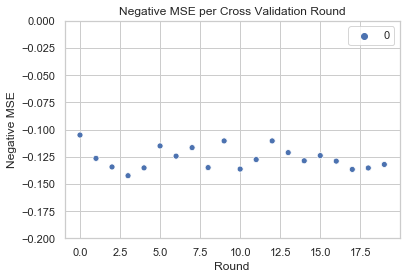

In [43]:
sns.scatterplot(data=cross_val)
plt.ylim(-.2,0)
plt.ylabel('Negative MSE')
plt.xlabel('Round')
plt.title('Negative MSE per Cross Validation Round')

plt.show()

# Model Discussion

The r-squared and adjusted r-squared values for this model equal 0.70 and 0.69, respectively. The equality of these two values indicates that the model is a reasonable fit to the data and it avoided over fitting. Additionally, the mean squared error (MSE) between the training and testing data sets across 20 cross validations ranges from 0.10 to 0.14 (displayed on graph above). Not only are these values close to zero (indicating small variance between the actual sale price and predicted sale price), they also cluster in a relatively tight range (indicating model reliability). 

This model is heavily based on location as 27 of its 29 features are related to zipcodes. The two non-zipcode features selected were 'sqft_living' and 'waterfront' with coefficients of 0.453 and 1.001, respectively. Both of these features have a positive affect on the sale price of the house beacuse the coefficient values are positive. Furthermore, 'sqft_living' has twice as large of an affect on the sale price as 'waterfront' because the coefficient for 'sqft_living' is twice as large as the coefficient for 'waterfront'. The largest coeffeicient for the zipcode features in the model is 1.751 for 'zipcode_98039'. Again, the positive value of the coefficient indicates a positive affect on the sale price and the magnitude of the value indicates the measure of its effect on the sale price.



# Project Approach

A linear model depends on normal, linear, and homoscedastic data. Thus, the approach for this project was to transform the data as best as possible to meet these requirements. Standardizing the data set to z-score values centered each feature's values around zero and resulted in similar ranges. This method also allowed for the identification of outliers as every value of the standardized data point now represents its distance from its mean. An outlier was defined as the absolute value of any standardized data point greater than 3 and these data points were subsequently removed from the data set. Sparse data in in the 'sqft_basement' feature was binned to create a more normal distribution and to represent categories for no basement, small basement, medium basement, and large basement. Sparse data in the 'yr_renovated' column was binarized to represent whether the house had undergone repairs. This was a fair transformation of the data as the year of renovation does not indicate the extent of the renovation, thus all renovation efforts were treated as equal.

As stated in the model discussion, the model is heavily influenced by location. While location is an important factor in real estate, it is not the only factor and this model could be made more helpful to potential sellers if more features were included that reflected their ability to modify their house. Given more time I would like to explore the effects of including bedrooms, bathrooms, and condition as features in the model. This would give sellers the ability to differentiate whether adding a bedroom or a bathroom would yeild a greater sale price.